# Running MATILDA for the training period

- create settings.yaml (here or in the other Notebooks)
- run MATILDA with default parameters
- (split in calibration and validation samples)
- run mspot with few iterations
- write best parameter set to yaml
- run matilda with best parameter set

Some helper functions to work with yaml files

In [1]:
import yaml

def read_yaml(file_path):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        return data
    
def write_yaml(data, file_path):
    with open(file_path, 'w') as f:
        yaml.safe_dump(data, f)

def update_yaml(file_path, new_items):
    data = read_yaml(file_path)
    data.update(new_items)
    write_yaml(data, file_path)


Read data required for MATILDA from the config file

In [2]:
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get output dir and date range from config.ini
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
date_range = ast.literal_eval(config['CONFIG']['DATE_RANGE'])

Derive setup and modeling periods from the defined time period. Default is to use the first two years as spinup.

In [3]:
import pandas as pd

length_of_setup_period = 2

sim_start = pd.to_datetime(date_range[0]) + pd.DateOffset(years = length_of_setup_period)
set_up_end = sim_start - pd.DateOffset(days = 1)

dates = {'set_up_start': date_range[0],
        'set_up_end': str(set_up_end).split(' ')[0],        # remove hh:mm:ss
        'sim_start': str(sim_start).split(' ')[0],          # remove hh:mm:ss
        'sim_end': date_range[1]}

print(dates)

{'set_up_start': '1982-01-01', 'set_up_end': '1983-12-31', 'sim_start': '1984-01-01', 'sim_end': '1991-12-31'}


Append the dates to the settings.yml with stored catchment information.

In [4]:
update_yaml(dir_output + 'settings.yml', dates)


Check the remaining settings, append them to the settings file and load it as a dictionary.

In [9]:
remaining_settings = {"freq": "M",            # aggregation level of model outputs (D, M, Y)
                      "warn": False,          # show warnings of subpackages?
                      "plot_type": "all",     # interactive and/or non-interactive plots ('print', 'interactive', 'all')
                      "elev_rescaling": True # 
                     }

update_yaml(dir_output + 'settings.yml', remaining_settings)

settings = read_yaml(dir_output + 'settings.yml')


# Run MATILDA with default parameters

Load forcing and obs data

In [10]:
era5 = pd.read_csv(dir_output + 'ERA5L.csv', usecols=['temp', 'prec', 'dt'])
era5.columns = ['T2', 'RRR', 'TIMESTAMP']

obs = pd.read_csv('input/' + 'Kyzylsuu_1982_2020_latest.csv')

glacier_profile = pd.read_csv(dir_output + 'glacier_profile_header_we_edited.csv')

settings.pop('glacier_profile')    # only the path to the profile is included in settings.yaml --> remove


'output/glacier_profile.csv'

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1982-01-01
set_up_end       1983-12-31
sim_start        1984-01-01
sim_end          1991-12-31
freq                      M
freq_long           Monthly
lat               42.183108
area_cat         295.276348
area_glac           31.8137
ele_dat         3337.712033
ele_cat         3295.476562
ele_glac        4001.879883
ele_non_glac    3210.176791
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp              -0.006
lr_prec                   0
TT_snow                   0
TT_rain                   2
TT_diff                   2
CFMAX_snow              2.5
CFMAX_ice                 5
CFMAX_rel                 2
BETA                    1.0
CET                    0.15
FC                      250
K0                    0.055
K1                    0.055
K2                     0.04
LP                      0.7
MAXBAS                  3

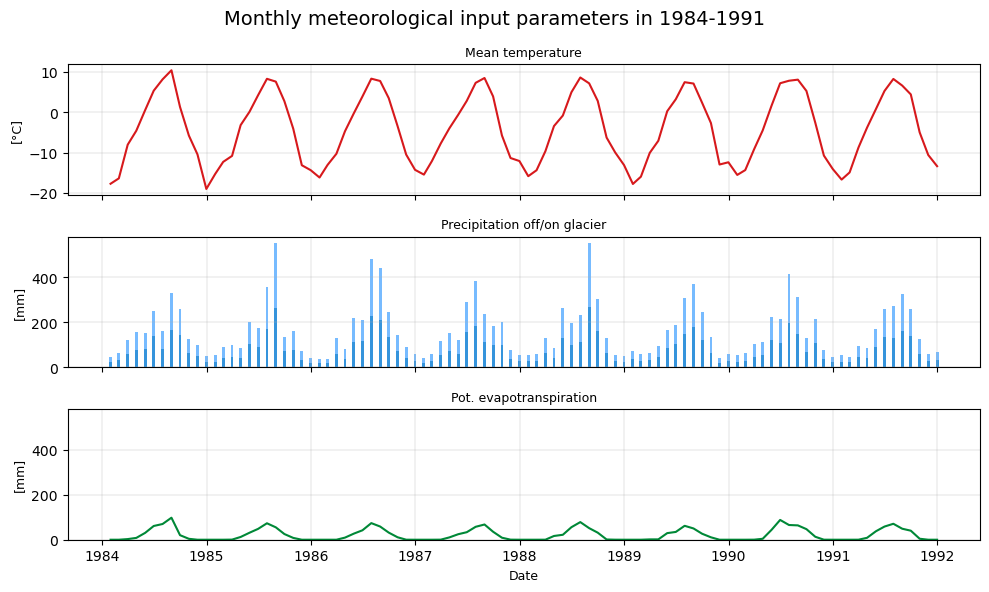

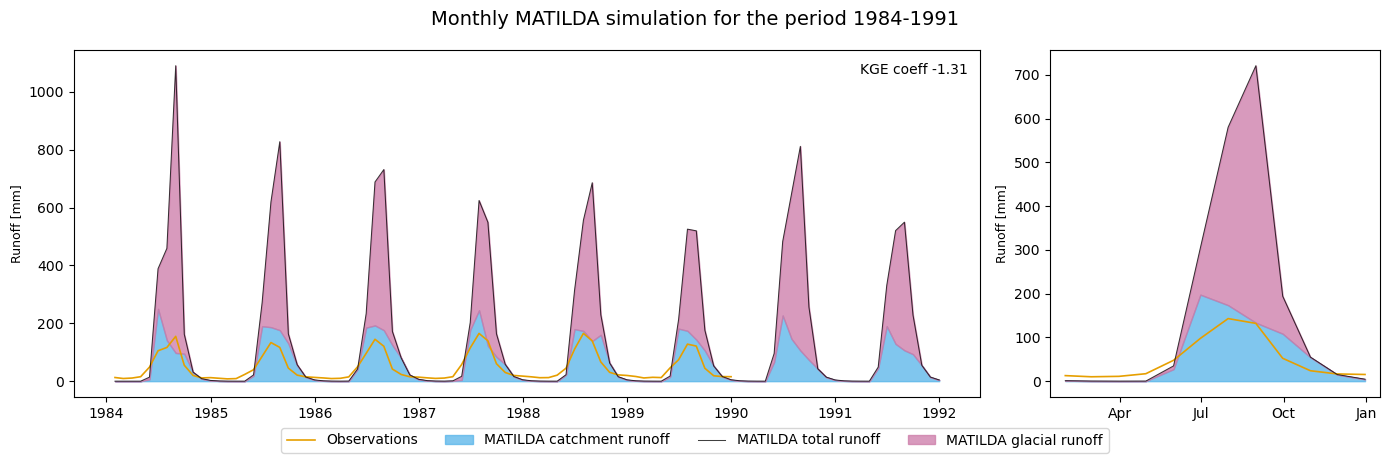

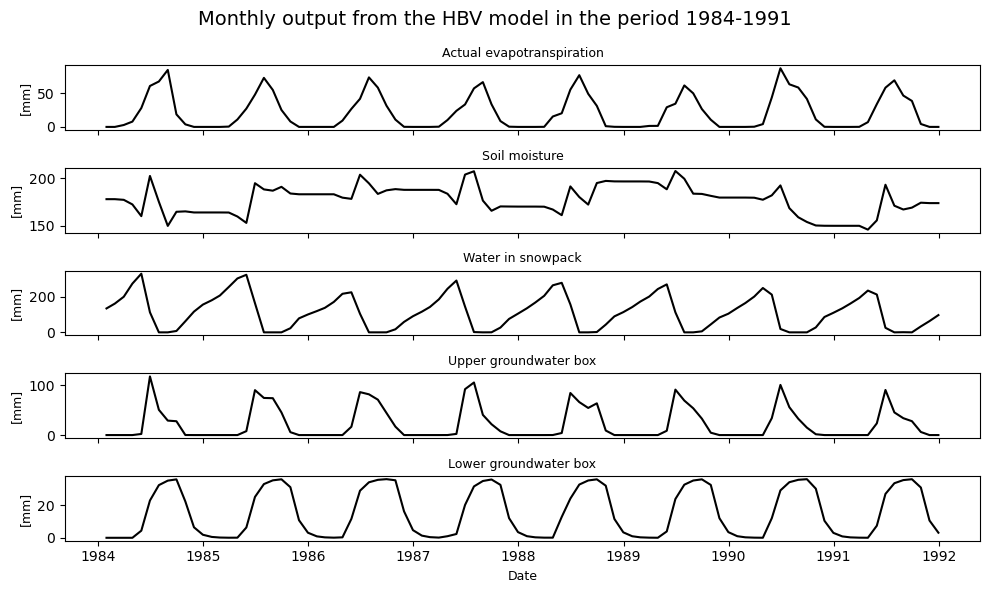

In [11]:
from matilda.core import matilda_simulation

output_MATILDA = matilda_simulation(era5, obs, glacier_profile=glacier_profile, **settings)

This is obviously an incorrect result so the model requires calibration.

# Run MATILDA with calibrated parameters

Pass best parameter set from calibration runs as dictionary.

In [12]:
param_dict = param = {'lr_temp': -0.005731264501416188,
 'lr_prec': 0.0006321153951009813,
 'BETA': 3.2809397625369074,
 'CET': 0.0618835023055286,
 'FC': 172.58291412512943,
 'K0': 0.3336631972725065,
 'K1': 0.08704195120845251,
 'K2': 0.026932777098937797,
 'LP': 0.6497346961851069,
 'MAXBAS': 3.7908882735193266,
 'PERC': 1.5043618702666255,
 'UZL': 459.92426025998134,
 'PCORR': 0.500539563419565,
 'TT_snow': -1.2663309317186,
 'TT_diff': 1.9499010761288165,
 'CFMAX_ice': 1.8071646497454978,
 'CFMAX_rel': 2.3318304860238257,
 'SFCF': 0.8207791051533044,
 'CWH': 0.14592976146729994,
 'AG': 0.28854573076827994,
 'RFS': 0.21311962035870669}

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1982-01-01
set_up_end       1983-12-31
sim_start        1984-01-01
sim_end          1991-12-31
freq                      M
freq_long           Monthly
lat               42.183108
area_cat         295.276348
area_glac           31.8137
ele_dat         3337.712033
ele_cat         3295.476562
ele_glac        4001.879883
ele_non_glac    3210.176791
hydro_year               10
soi                    None
warn                  False
pfilter                   0
lr_temp           -0.005731
lr_prec            0.000632
TT_snow           -1.266331
TT_rain             0.68357
TT_diff            1.949901
CFMAX_snow         0.774998
CFMAX_ice          1.807165
CFMAX_rel           2.33183
BETA                3.28094
CET                0.061884
FC               172.582914
K0                 0.333663
K1                 0.087042
K2                 0.026933
LP                 0.649735
MAXBAS             3.7908

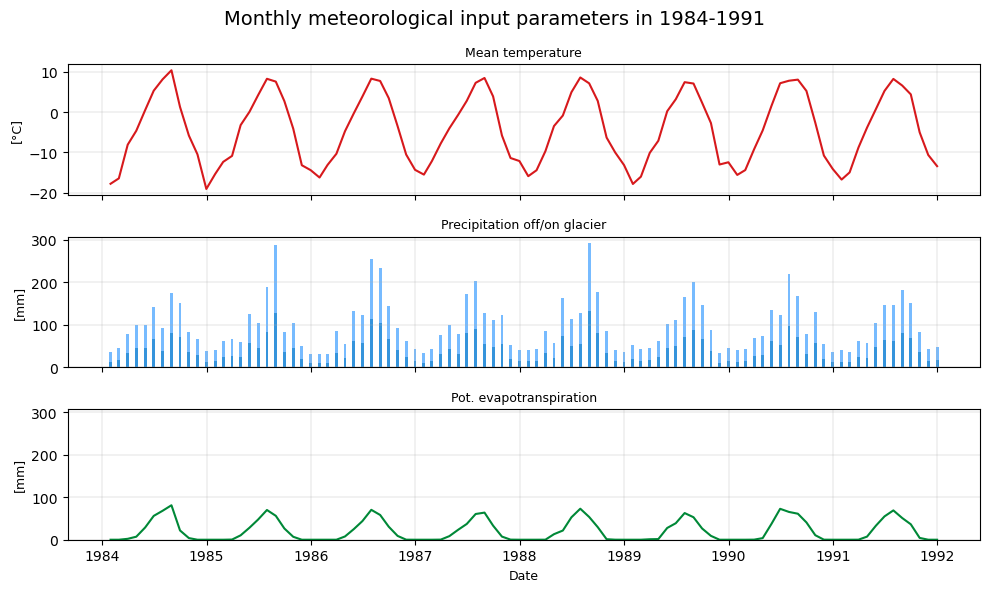

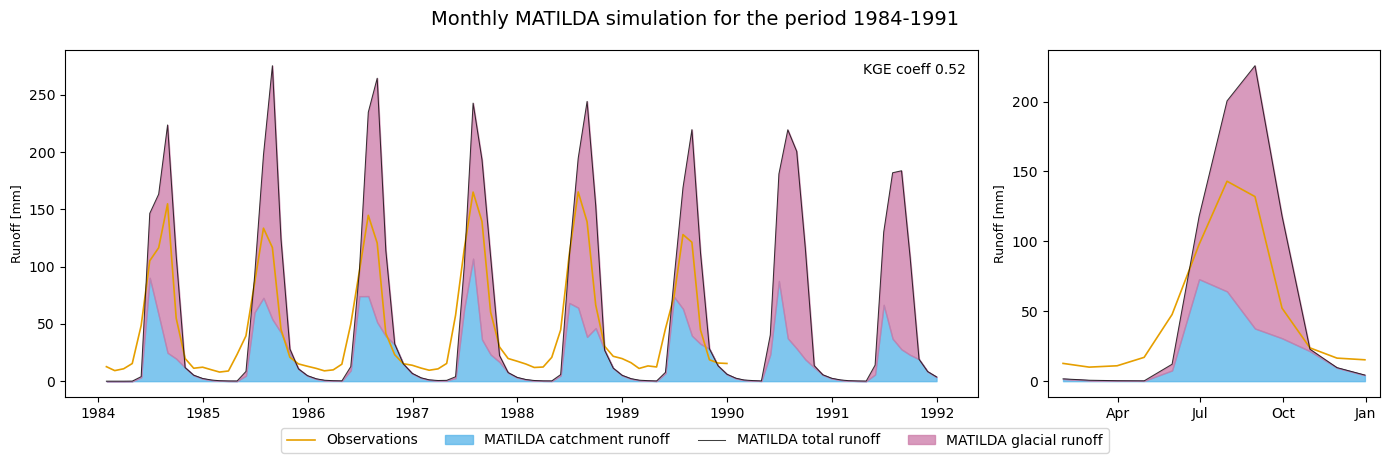

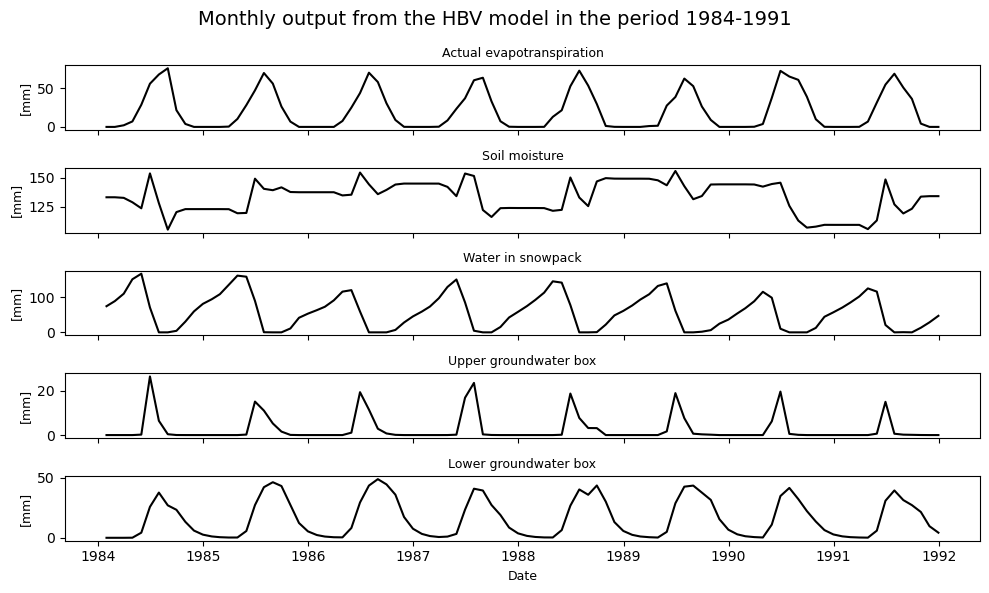

In [13]:
output_MATILDA = matilda_simulation(era5, obs, glacier_profile=glacier_profile, **settings, parameter_set = param_dict)

# DIE GLETSCHER SIND ZU WARM. ES LIEGT AM GLETSCHERPROFIL